# XGBoost Regressor for Wind Power Generation

Improvements:
- Time Series Cross Validation
- XGBoost

## Data Preprocessing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

### Output Variables

In [2]:
# 2022 values of wind power generation expressed as capacity factor (ratio of actual generation to installed capacity)
# file size: 138MB
ds = xr.open_dataset('data/output/UKwindgen_2022.nc')

# Fill NaN values with zero
ds = ds.fillna(0)

# combine offshore and onshore wind data into a single column
ds['wind_power'] = ds['wofcfr'] + ds['woncfr']

In [3]:
output_vars=ds['wind_power'].to_dataframe()
output_vars

wind_power
time                latitude longitude            
2022-01-01 00:00:00 60.0     -10.00            1.0
                             -9.75             1.0
                             -9.50             1.0
                             -9.25             1.0
                             -9.00             1.0
...                                            ...
2022-12-31 23:00:00 50.0      1.00             1.0
                              1.25             1.0
                              1.50             1.0
                              1.75             1.0
                              2.00             1.0

[17598840 rows x 1 columns]

In [4]:
output_vars.info()
output_vars.describe()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17598840 entries, (Timestamp('2022-01-01 00:00:00'), 60.0, -10.0) to (Timestamp('2022-12-31 23:00:00'), 50.0, 2.0)
Data columns (total 1 columns):
 #   Column      Dtype  
---  ------      -----  
 0   wind_power  float32
dtypes: float32(1)
memory usage: 134.6 MB


,wind_power
count,1.759884e+07
mean,5.272247e-01
std,3.993001e-01
min,0.000000e+00
25%,1.168812e-01
50%,4.997049e-01
75%,9.926648e-01
max,1.001403e+00


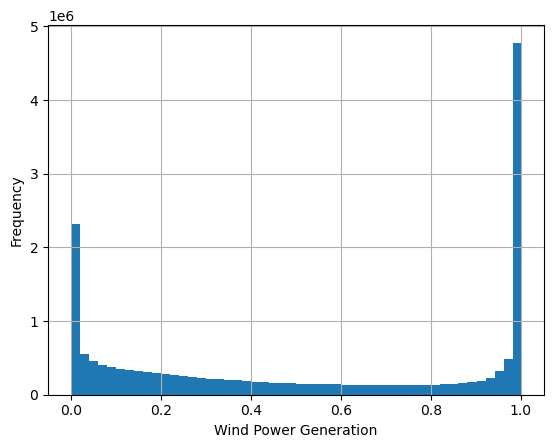

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot a histogram for power generation
output_vars['wind_power'].hist(bins=50)
plt.xlabel('Wind Power Generation')
plt.ylabel('Frequency')
plt.show()

<Axes: title={'center': 'Wind Power Generation at (59.0,-9.25) in 2022'}, xlabel='time'>

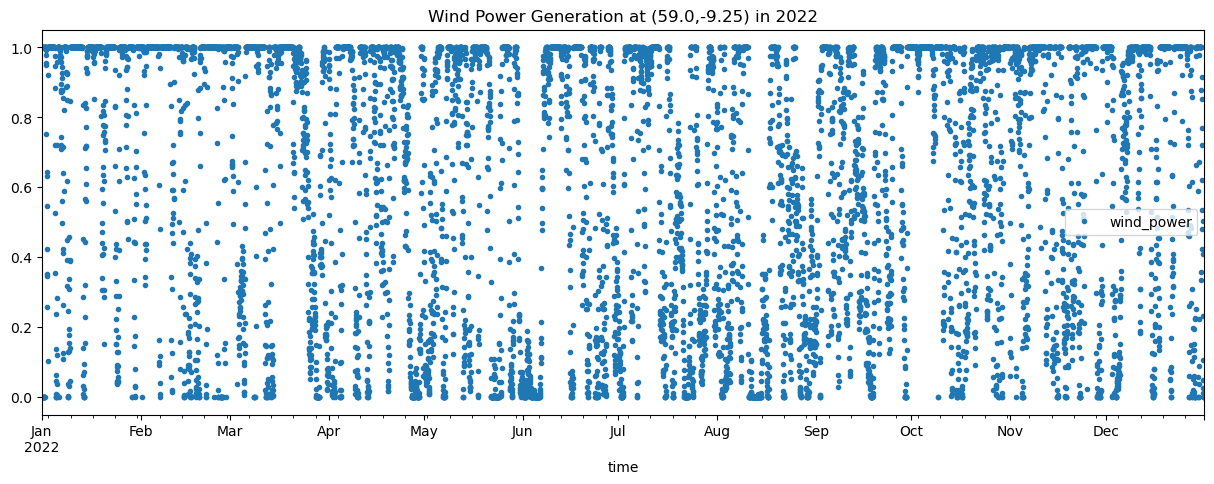

In [6]:
data=output_vars.loc[(slice(None), 59.0, -9.25), 'wind_power']
data = data.to_frame()
data =data.reset_index()
data = data.drop(columns=['latitude', 'longitude'])
data = data.set_index('time')
data.plot(style='.', figsize=(15,5), title='Wind Power Generation at (59.0,-9.25) in 2022')

In [7]:
# import geopandas as gpd
# data=output_vars.loc[('2022-05-20 16:00'), 'wind_power']
# data = data.to_frame().reset_index()

# # Convert the DataFrame to a GeoDataFrame
# gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['longitude'], data['latitude']))

# # Load a shapefile or map data (e.g., world map)
# map_data = gpd.read_file('<path_to_shapefile>')

# # Perform a spatial join to associate the wind power data with the map data
# merged = gpd.sjoin(map_data, gdf, how='inner', op='contains')

# # Plot the wind power column on the map
# fig, ax = plt.subplots(figsize=(12, 8))
# merged.plot(column='wind_power', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# # Customize the plot
# ax.set_title('Wind Power Distribution Map')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')

# plt.show()

### Input Variables

10m U and V components of wind (10u,10v), 2m Temperature (2t), Surface Pressure (sp), and Mean Sea Level Pressure (msl) from the ECMWF MARS data operational archive.

In [8]:
ds = xr.open_dataset('./data/input/10u-10v-2t-sp-msl_2022.grib', engine='cfgrib')
ds

<xarray.Dataset>
Dimensions:     (time: 730, step: 12, latitude: 41, longitude: 49)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2022-01-01 ... 2022-12-31T12:00:00
  * step        (step) timedelta64[ns] 00:00:00 01:00:00 ... 10:00:00 11:00:00
    surface     float64 ...
  * latitude    (latitude) float64 60.0 59.75 59.5 59.25 ... 50.5 50.25 50.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 1.25 1.5 1.75 2.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    sp          (time, step, latitude, longitude) float32 ...
    msl         (time, step, latitude, longitude) float32 ...
    u10         (time, step, latitude, longitude) float32 ...
    v10         (time, step, latitude, longitude) float32 ...
    t2m         (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-06-07T01:50 GRIB to CDM+CF via cfgrib-0.9.1...

#### Feature Creation

##### Wind Speed and Direction

In [9]:
u_wind = ds['u10']
v_wind = ds['v10']

wind_speed = np.sqrt(u_wind**2 + v_wind**2)
wind_direction = np.arctan2(v_wind, u_wind) * (180 / np.pi)

# Adjust wind direction to range from 0 to 360 degrees
wind_direction = (wind_direction + 360) % 360

ds['wind_speed'] = wind_speed
ds['wind_direction'] = wind_direction

##### Time Series Features

In [10]:
# Create day of week feature
ds['dayofweek'] = ds.valid_time.dt.dayofweek

# Create hour feature
ds['hour'] = ds.valid_time.dt.hour

# Create day of year feature
ds['dayofyear'] = ds.valid_time.dt.dayofyear

In [11]:
# Optimize data types
ds['dayofweek'] = ds.dayofweek.astype('int8')
ds['hour'] = ds.hour.astype('int8')
ds['dayofyear'] = ds.dayofyear.astype('int16')

In [12]:
ds

<xarray.Dataset>
Dimensions:         (time: 730, step: 12, latitude: 41, longitude: 49)
Coordinates:
    number          int64 ...
  * time            (time) datetime64[ns] 2022-01-01 ... 2022-12-31T12:00:00
  * step            (step) timedelta64[ns] 00:00:00 01:00:00 ... 11:00:00
    surface         float64 ...
  * latitude        (latitude) float64 60.0 59.75 59.5 59.25 ... 50.5 50.25 50.0
  * longitude       (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 1.5 1.75 2.0
    valid_time      (time, step) datetime64[ns] 2022-01-01 ... 2022-12-31T23:...
Data variables:
    sp              (time, step, latitude, longitude) float32 ...
    msl             (time, step, latitude, longitude) float32 ...
    u10             (time, step, latitude, longitude) float32 -13.55 ... 4.066
    v10             (time, step, latitude, longitude) float32 5.913 ... 7.377
    t2m             (time, step, latitude, longitude) float32 ...
    wind_speed      (time, step, latitude, longitude) float32 14.78 ... 8.423
    wind_direction  (time, step, latitude, longitude) float32 156.4 ... 61.14
    dayofweek       (time, step) int8 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 5
    hour            (time, step) int8 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
    dayofyear       (time, step) int16 1 1 1 1 1 1 1 ... 365 365 365 365 365 365
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-06-07T01:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [13]:
input_vars = ds[['sp', 'msl', 'wind_speed', 'wind_direction', 't2m', 'dayofweek', 'hour', 'dayofyear']].to_dataframe()
input_vars = input_vars.reset_index(['time','step'])
input_vars = input_vars.set_index('valid_time', append=True)
input_vars = input_vars.drop(columns=['time', 'step', 'number', 'surface'])
input_vars = input_vars.rename_axis(index={'valid_time': 'time'})
input_vars

sp           msl  wind_speed   
latitude longitude time                                                         
60.0     -10.00    2022-01-01 00:00:00  100060.8125  100050.43750   14.779819  \
         -9.75     2022-01-01 00:00:00  100087.8125  100091.18750   15.066580   
         -9.50     2022-01-01 00:00:00  100133.0625  100131.06250   15.045078   
         -9.25     2022-01-01 00:00:00  100173.5625  100169.12500   14.930349   
         -9.00     2022-01-01 00:00:00  100205.0625  100207.18750   14.599252   
...                                             ...           ...         ...   
50.0      1.00     2022-12-31 23:00:00  100830.0000  100913.90625   12.745411   
          1.25     2022-12-31 23:00:00  100347.2500  100947.56250   11.170109   
          1.50     2022-12-31 23:00:00   99725.7500  100981.90625    9.644139   
          1.75     2022-12-31 23:00:00   99885.2500  101010.78125    9.110554   
          2.00     2022-12-31 23:00:00  100197.7500  101043.12500    8.423323   

                                        wind_direction         t2m  dayofweek   
latitude longitude time                                                         
60.0     -10.00    2022-01-01 00:00:00      156.416443  282.184082          5  \
         -9.75     2022-01-01 00:00:00      156.276489  282.195312          5   
         -9.50     2022-01-01 00:00:00      156.919373  282.168213          5   
         -9.25     2022-01-01 00:00:00      157.850830  282.138428          5   
         -9.00     2022-01-01 00:00:00      158.328735  282.122803          5   
...                                                ...         ...        ...   
50.0      1.00     2022-12-31 23:00:00       62.984619  286.771240          5   
          1.25     2022-12-31 23:00:00       67.306946  286.460205          5   
          1.50     2022-12-31 23:00:00       64.060608  286.519287          5   
          1.75     2022-12-31 23:00:00       61.843445  286.656982          5   
          2.00     2022-12-31 23:00:00       61.139893  287.161865          5   

                                        hour  dayofyear  
latitude longitude time                                  
60.0     -10.00    2022-01-01 00:00:00     0          1  
         -9.75     2022-01-01 00:00:00     0          1  
         -9.50     2022-01-01 00:00:00     0          1  
         -9.25     2022-01-01 00:00:00     0          1  
         -9.00     2022-01-01 00:00:00     0          1  
...                                      ...        ...  
50.0      1.00     2022-12-31 23:00:00    23        365  
          1.25     2022-12-31 23:00:00    23        365  
          1.50     2022-12-31 23:00:00    23        365  
          1.75     2022-12-31 23:00:00    23        365  
          2.00     2022-12-31 23:00:00    23        365  

[17598840 rows x 8 columns]

In [14]:
input_vars.describe()

,sp,msl,wind_speed,wind_direction,t2m,dayofweek,hour,dayofyear
count,1.759884e+07,1.759884e+07,1.759884e+07,1.759884e+07,1.759884e+07,1.759884e+07,1.759884e+07,1.759884e+07
mean,1.007162e+05,1.013447e+05,6.884026e+00,1.519499e+02,2.837675e+02,3.005479e+00,1.150000e+01,1.830000e+02
std,1.672539e+03,1.212050e+03,3.869098e+00,1.128439e+02,4.363852e+00,1.999993e+00,6.922187e+00,1.053660e+02
min,8.858144e+04,9.635206e+04,1.663841e-03,0.000000e+00,2.576187e+02,0.000000e+00,0.000000e+00,1.000000e+00
25%,9.984925e+04,1.005905e+05,3.851393e+00,5.351385e+01,2.808669e+02,1.000000e+00,5.750000e+00,9.200000e+01
50%,1.009708e+05,1.014709e+05,6.265473e+00,1.184171e+02,2.838157e+02,3.000000e+00,1.150000e+01,1.830000e+02
75%,1.018881e+05,1.022034e+05,9.368141e+00,2.573734e+02,2.866653e+02,5.000000e+00,1.725000e+01,2.740000e+02
max,1.047943e+05,1.047853e+05,3.138975e+01,3.600000e+02,3.125989e+02,6.000000e+00,2.300000e+01,3.650000e+02


In [15]:
input_vars.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17598840 entries, (60.0, -10.0, Timestamp('2022-01-01 00:00:00')) to (50.0, 2.0, Timestamp('2022-12-31 23:00:00'))
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   sp              float32
 1   msl             float32
 2   wind_speed      float32
 3   wind_direction  float32
 4   t2m             float32
 5   dayofweek       int8   
 6   hour            int8   
 7   dayofyear       int16  
dtypes: float32(5), int16(1), int8(2)
memory usage: 470.3 MB


### Merge Datasets

In [16]:
# Resetting the index of both DataFrames to prepare for merging
input_df = input_vars.reset_index()
output_df = output_vars.reset_index()

# Merging the predicted and actual DataFrames based on the common index columns
merged_df = input_df.merge(output_df, on=['latitude', 'longitude', 'time'])
merged_df

,latitude,longitude,time,sp,msl,wind_speed,wind_direction,t2m,dayofweek,hour,dayofyear,wind_power
0,60.0,-10.00,2022-01-01 00:00:00,100060.8125,100050.43750,14.779819,156.416443,282.184082,5,0,1,1.0
1,60.0,-9.75,2022-01-01 00:00:00,100087.8125,100091.18750,15.066580,156.276489,282.195312,5,0,1,1.0
2,60.0,-9.50,2022-01-01 00:00:00,100133.0625,100131.06250,15.045078,156.919373,282.168213,5,0,1,1.0
3,60.0,-9.25,2022-01-01 00:00:00,100173.5625,100169.12500,14.930349,157.850830,282.138428,5,0,1,1.0
4,60.0,-9.00,2022-01-01 00:00:00,100205.0625,100207.18750,14.599252,158.328735,282.122803,5,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17598835,50.0,1.00,2022-12-31 23:00:00,100830.0000,100913.90625,12.745411,62.984619,286.771240,5,23,365,1.0
17598836,50.0,1.25,2022-12-31 23:00:00,100347.2500,100947.56250,11.170109,67.306946,286.460205,5,23,365,1.0
17598837,50.0,1.50,2022-12-31 23:00:00,99725.7500,100981.90625,9.644139,64.060608,286.519287,5,23,365,1.0
17598838,50.0,1.75,2022-12-31 23:00:00,99885.2500,101010.78125,9.110554,61.843445,286.656982,5,23,365,1.0


#### Correlation Matrix

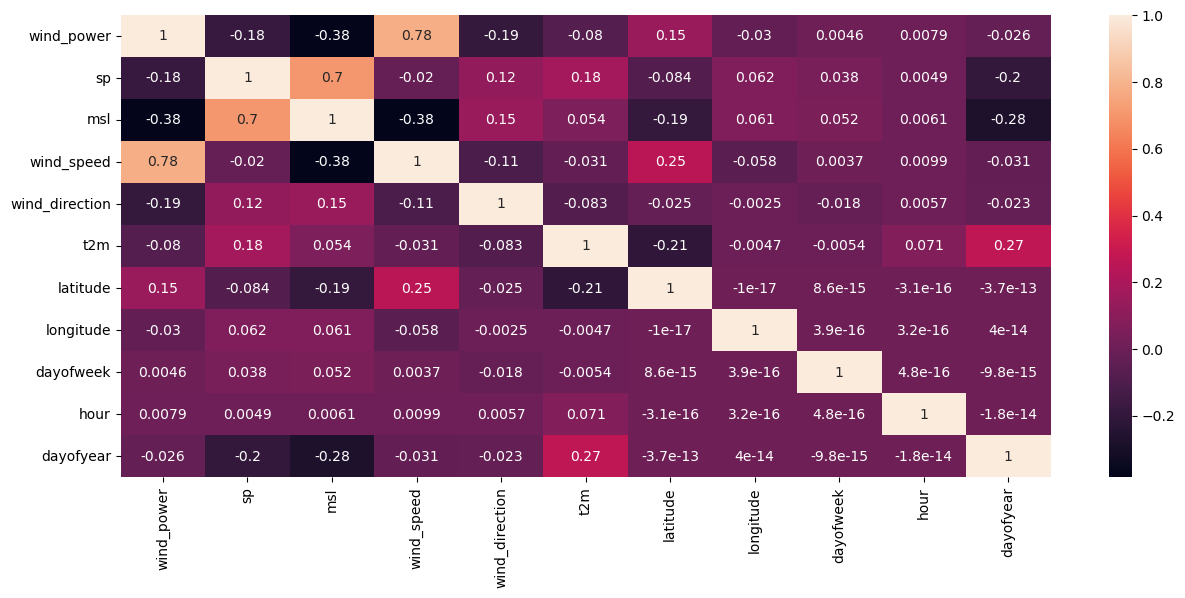

In [17]:
plt.figure(figsize=(15, 6))
correlation_matrix = merged_df[['wind_power', 'sp', 'msl', 'wind_speed', 'wind_direction', 't2m', 'latitude', 'longitude', 'dayofweek', 'hour', 'dayofyear']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [18]:
merged_df = merged_df.drop(columns=['dayofweek', 'hour', 'dayofyear'])

In [19]:
# Convert latitude and longitude columns to float32
merged_df['latitude'] = merged_df['latitude'].astype('float32')
merged_df['longitude'] = merged_df['longitude'].astype('float32')

In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17598840 entries, 0 to 17598839
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   latitude        float32       
 1   longitude       float32       
 2   time            datetime64[ns]
 3   sp              float32       
 4   msl             float32       
 5   wind_speed      float32       
 6   wind_direction  float32       
 7   t2m             float32       
 8   wind_power      float32       
dtypes: datetime64[ns](1), float32(8)
memory usage: 671.3 MB


## Time Series Cross Validation

In [21]:
from sklearn.model_selection import TimeSeriesSplit

In [22]:
merged_df

,latitude,longitude,time,sp,msl,wind_speed,wind_direction,t2m,wind_power
0,60.0,-10.00,2022-01-01 00:00:00,100060.8125,100050.43750,14.779819,156.416443,282.184082,1.0
1,60.0,-9.75,2022-01-01 00:00:00,100087.8125,100091.18750,15.066580,156.276489,282.195312,1.0
2,60.0,-9.50,2022-01-01 00:00:00,100133.0625,100131.06250,15.045078,156.919373,282.168213,1.0
3,60.0,-9.25,2022-01-01 00:00:00,100173.5625,100169.12500,14.930349,157.850830,282.138428,1.0
4,60.0,-9.00,2022-01-01 00:00:00,100205.0625,100207.18750,14.599252,158.328735,282.122803,1.0
...,...,...,...,...,...,...,...,...,...
17598835,50.0,1.00,2022-12-31 23:00:00,100830.0000,100913.90625,12.745411,62.984619,286.771240,1.0
17598836,50.0,1.25,2022-12-31 23:00:00,100347.2500,100947.56250,11.170109,67.306946,286.460205,1.0
17598837,50.0,1.50,2022-12-31 23:00:00,99725.7500,100981.90625,9.644139,64.060608,286.519287,1.0
17598838,50.0,1.75,2022-12-31 23:00:00,99885.2500,101010.78125,9.110554,61.843445,286.656982,1.0


In [23]:
# Sort the DataFrame by the time column
merged_df = merged_df.set_index(['time', 'latitude', 'longitude'])
merged_df = merged_df.sort_index()
merged_df

sp           msl  wind_speed   
time                latitude longitude                                          
2022-01-01 00:00:00 50.0     -10.00     100191.0625  100189.18750   18.968277  \
                             -9.75      100279.0625  100273.50000   18.848972   
                             -9.50      100369.5625  100361.62500   18.666565   
                             -9.25      100454.0625  100452.81250   18.465504   
                             -9.00      100534.3125  100535.18750   18.272722   
...                                             ...           ...         ...   
2022-12-31 23:00:00 60.0      1.00      100139.2500  100131.28125    4.370730   
                              1.25      100121.5000  100127.90625    4.637717   
                              1.50      100138.2500  100127.53125    4.634398   
                              1.75      100127.7500  100126.56250    4.592044   
                              2.00      100118.5000  100124.46875    4.857903   

                                        wind_direction         t2m  wind_power  
time                latitude longitude                                          
2022-01-01 00:00:00 50.0     -10.00          90.899597  288.133301         0.0  
                             -9.75           91.199219  288.118896         0.0  
                             -9.50           90.915649  288.109863         0.0  
                             -9.25           90.139282  288.048828         0.0  
                             -9.00           89.523712  288.012939         1.0  
...                                                ...         ...         ...  
2022-12-31 23:00:00 60.0      1.00          256.139008  276.592529         0.0  
                              1.25          256.629303  276.685303         0.0  
                              1.50          256.284241  276.685791         0.0  
                              1.75          257.756226  276.573975         0.0  
                              2.00          261.040466  276.599365         0.0  

[17598840 rows x 6 columns]

In [24]:
# Initialize the TimeSeriesSplit object
tss = TimeSeriesSplit(n_splits=5)

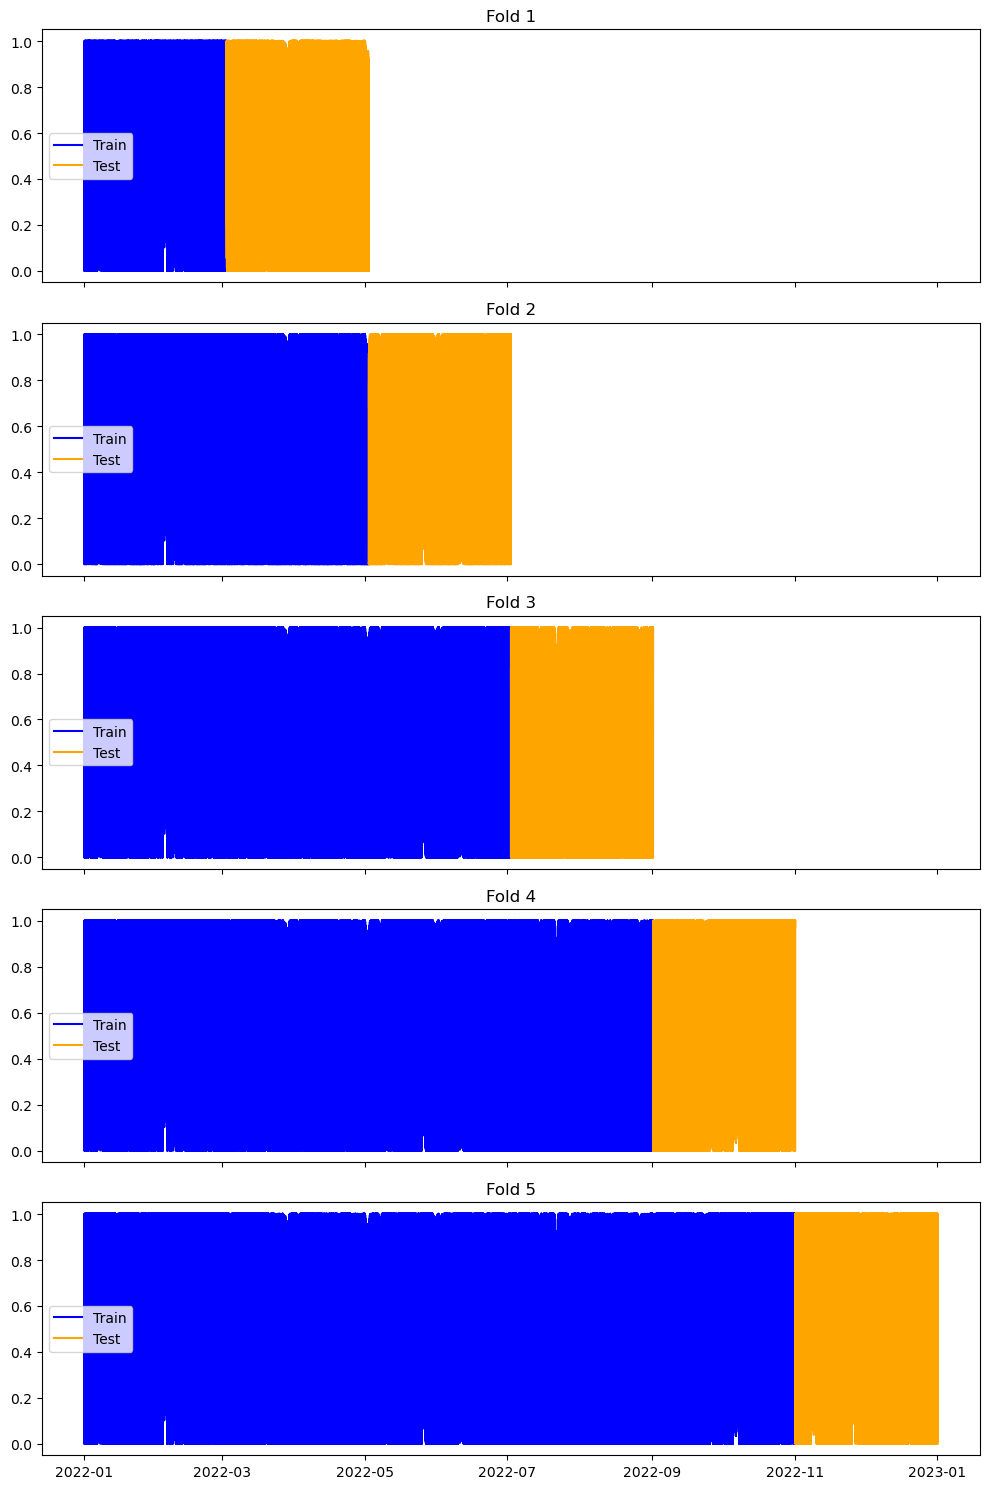

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(tss.n_splits,figsize=(10,15), sharex=True)

for i, (train_index, test_index) in enumerate(tss.split(merged_df)):
    # Select the data at the train and test indices
    train = merged_df.iloc[train_index]
    test = merged_df.iloc[test_index]
    
    # Select only the 'time' level of the index for plotting
    train_time = train.index.get_level_values('time')
    test_time = test.index.get_level_values('time')

    # Assume that 'value' is the column of data you want to plot
    axs[i].plot(train_time, train['wind_power'], color='blue')
    axs[i].plot(test_time, test['wind_power'], color='orange')
    axs[i].set_title(f"Fold {i+1}")
    axs[i].legend(["Train", "Test"], loc='center left')

# Show the plot
plt.tight_layout()
plt.show()

## XGBoost Model

In [26]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [27]:
from sklearn.preprocessing import MinMaxScaler
# create a scaler object
scaler = MinMaxScaler()

In [28]:
scores=[]
preds=[]
errors=[]
for i, (train_index, test_index) in enumerate(tss.split(merged_df)):
    # Select the data at the train and test indices
    train = merged_df.iloc[train_index].copy()
    test = merged_df.iloc[test_index].copy()
    
    # Select only the 'time' level of the index for plotting
    train_time = train.index.get_level_values('time')
    test_time = test.index.get_level_values('time')
    
    FEATURES = ['sp', 'msl', 'wind_speed', 'wind_direction', 't2m']
    TARGET = 'wind_power'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    # Normalize Input Variables using MinMaxScaler     
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = xgb.XGBRegressor(n_estimators=1000, 
                             early_stopping_rounds=50)
    model.fit(X_train, y_train, 
              eval_set=[(X_train, y_train), (X_test, y_test)], 
              verbose=50)
    
     # Make predictions
    y_pred = model.predict(X_test)
    # predictions should only be between 0 and 1
    y_pred = np.where(y_pred > 1, 1, y_pred)
    y_pred = np.where(y_pred < 0, 0, y_pred)
    preds.append(y_pred)
    
    # Calculate the RMSE scores for each train and test set i.e. each fold
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    scores.append({
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
    })
    
    # calculate the error for each prediction
    error = y_test - y_pred
    test.loc[:, 'error'] = np.abs(y_test - y_pred)
    errors.append(error.values)

[0]	validation_0-rmse:0.32720	validation_1-rmse:0.31699
[50]	validation_0-rmse:0.14616	validation_1-rmse:0.17810
[86]	validation_0-rmse:0.14330	validation_1-rmse:0.18325
[0]	validation_0-rmse:0.31701	validation_1-rmse:0.30573
[50]	validation_0-rmse:0.14909	validation_1-rmse:0.17273
[81]	validation_0-rmse:0.14668	validation_1-rmse:0.17430
[0]	validation_0-rmse:0.31215	validation_1-rmse:0.29725
[50]	validation_0-rmse:0.15175	validation_1-rmse:0.15800
[73]	validation_0-rmse:0.14997	validation_1-rmse:0.15934
[0]	validation_0-rmse:0.30848	validation_1-rmse:0.30268
[50]	validation_0-rmse:0.15118	validation_1-rmse:0.17494
[100]	validation_0-rmse:0.14839	validation_1-rmse:0.17302
[150]	validation_0-rmse:0.14706	validation_1-rmse:0.17340
[160]	validation_0-rmse:0.14696	validation_1-rmse:0.17342
[0]	validation_0-rmse:0.30802	validation_1-rmse:0.31828
[50]	validation_0-rmse:0.15471	validation_1-rmse:0.17039
[100]	validation_0-rmse:0.15235	validation_1-rmse:0.16762
[150]	validation_0-rmse:0.15120	

In [29]:
# Display scores for each fold
for i, score in enumerate(scores):
    print(f"Fold {i+1}:")
    print(f"  Mean Absolute Error: {score['mae']}")
    print(f"  Mean Squared Error: {score['mse']}")
    print(f"  Root Mean Squared Error: {score['rmse']}")
    print(f"  R2 Score: {score['r2']}")

Fold 1:
  Mean Absolute Error: 0.12035498023033142
  Mean Squared Error: 0.030493678525090218
  Root Mean Squared Error: 0.17462439835071564
  R2 Score: 0.8043511771896861
Fold 2:
  Mean Absolute Error: 0.11319988965988159
  Mean Squared Error: 0.02932763285934925
  Root Mean Squared Error: 0.17125312983989716
  R2 Score: 0.8048016376853971
Fold 3:
  Mean Absolute Error: 0.10555487126111984
  Mean Squared Error: 0.024166584014892578
  Root Mean Squared Error: 0.1554560512304306
  R2 Score: 0.8028317150645874
Fold 4:
  Mean Absolute Error: 0.11394746601581573
  Mean Squared Error: 0.029851002618670464
  Root Mean Squared Error: 0.17277443408966064
  R2 Score: 0.797002301413708
Fold 5:
  Mean Absolute Error: 0.10666299611330032
  Mean Squared Error: 0.02775660529732704
  Root Mean Squared Error: 0.16660313308238983
  R2 Score: 0.8148870443645679


In [30]:
# Initialize the sums
sum_mae = 0
sum_mse = 0
sum_rmse = 0
sum_r2 = 0

# Sum up the scores
for score in scores:
    sum_mae += score['mae']
    sum_mse += score['mse']
    sum_rmse += score['rmse']
    sum_r2 += score['r2']

# Calculate the averages
avg_mae = sum_mae / len(scores)
avg_mse = sum_mse / len(scores)
avg_rmse = sum_rmse / len(scores)
avg_r2 = sum_r2 / len(scores)

print("Average Performance of Theoretical Function:")
print(f"  Mean Absolute Error: {avg_mae}")
print(f"  Mean Squared Error: {avg_mse}")
print(f"  Root Mean Squared Error: {avg_rmse}")
print(f"  R2 Score: {avg_r2}")

Average Performance of Theoretical Function:
  Mean Absolute Error: 0.11194404065608979
  Mean Squared Error: 0.02831910066306591
  Root Mean Squared Error: 0.16814222931861877
  R2 Score: 0.8047747751435892


In [31]:
# Flatten the errors
errors = np.concatenate(errors)

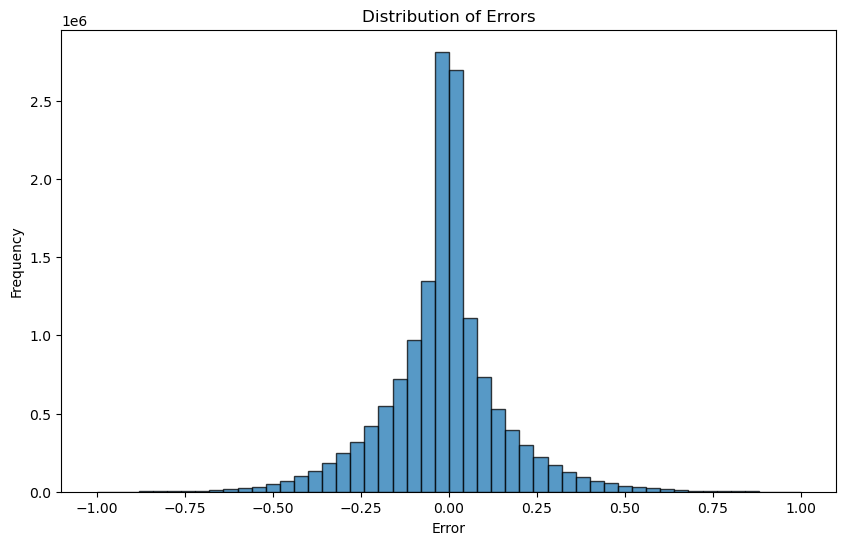

In [32]:
# Plotting the distribution of errors
plt.figure(figsize=(10,6))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.75)
plt.title('Distribution of Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

## Predicting the Future

In [33]:
# Retrain the model using all the data

FEATURES = ['sp', 'msl', 'wind_speed', 'wind_direction', 't2m']
TARGET = 'wind_power'

X_all = merged_df[FEATURES]
y_all = merged_df[TARGET]

model = xgb.XGBRegressor(n_estimators=1000,
                         early_stopping_rounds=50)
model.fit(X_all,y_all,
          eval_set=[(X_all, y_all)],
          verbose=50)

[0]	validation_0-rmse:0.30999
[50]	validation_0-rmse:0.15560
[100]	validation_0-rmse:0.15313
[150]	validation_0-rmse:0.15209
[200]	validation_0-rmse:0.15136
[250]	validation_0-rmse:0.15080
[300]	validation_0-rmse:0.15035
[350]	validation_0-rmse:0.14994
[400]	validation_0-rmse:0.14960
[450]	validation_0-rmse:0.14930
[500]	validation_0-rmse:0.14905
[550]	validation_0-rmse:0.14880
[600]	validation_0-rmse:0.14860
[650]	validation_0-rmse:0.14840
[700]	validation_0-rmse:0.14819
[750]	validation_0-rmse:0.14802
[800]	validation_0-rmse:0.14785
[850]	validation_0-rmse:0.14770
[900]	validation_0-rmse:0.14755
[950]	validation_0-rmse:0.14741
[999]	validation_0-rmse:0.14726


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Save Model

In [34]:
model.save_model('windModelV3.json')

## Evaluate how bad the predictions are based on region

In [35]:
import geopandas as gpd
import folium
from shapely.geometry import Point

In [60]:
# Load the GADM geopackage
gadm_uk = gpd.read_file('data/geopackage/gadm41_GBR_3.json')

In [61]:
# Convert your error data to a GeoDataFrame
gdf = gpd.GeoDataFrame(test, geometry=gpd.points_from_xy(test.index.get_level_values('longitude'), test.index.get_level_values('latitude')))
gdf.crs = "EPSG:4326"

In [62]:
# Perform a spatial join between the two GeoDataFrames
joined = gpd.sjoin(gdf, gadm_uk, predicate='within')

In [63]:
joined

sp           msl  wind_speed   
time                latitude longitude                                          
2022-11-01 04:00:00 50.00    -5.25      100260.3750  100469.25000   13.023680  \
                    50.25    -5.25       99573.1250  100404.62500    9.597396   
                             -5.00       99590.1250  100438.37500    9.397870   
                    50.50    -5.00       99879.1250  100361.43750   12.345274   
                             -4.75       98779.3750  100406.00000    7.203185   
...                                             ...           ...         ...   
2022-12-31 19:00:00 60.00    -1.25       99767.6250  100031.81250    1.725765   
2022-12-31 20:00:00 60.00    -1.25       99822.3125  100086.56250    1.865283   
2022-12-31 21:00:00 60.00    -1.25       99863.3750  100127.71875    1.726300   
2022-12-31 22:00:00 60.00    -1.25       99878.3125  100142.65625    1.748839   
2022-12-31 23:00:00 60.00    -1.25       99897.5000  100161.28125    1.698801   

                                        wind_direction         t2m   
time                latitude longitude                               
2022-11-01 04:00:00 50.00    -5.25           40.904022  286.868164  \
                    50.25    -5.25           41.784302  285.613281   
                             -5.00           39.850006  285.696777   
                    50.50    -5.00           41.985596  286.382568   
                             -4.75           47.936340  285.232178   
...                                                ...         ...   
2022-12-31 19:00:00 60.00    -1.25          265.112000  272.544678   
2022-12-31 20:00:00 60.00    -1.25          267.930908  271.832275   
2022-12-31 21:00:00 60.00    -1.25          256.243469  272.061523   
2022-12-31 22:00:00 60.00    -1.25          244.358154  272.394043   
2022-12-31 23:00:00 60.00    -1.25          236.871338  272.324463   

                                        wind_power         error   
time                latitude longitude                             
2022-11-01 04:00:00 50.00    -5.25        1.000000  9.573698e-04  \
                    50.25    -5.25        0.999991  1.454771e-02   
                             -5.00        1.000000  3.449404e-02   
                    50.50    -5.00        1.000000  0.000000e+00   
                             -4.75        1.000000  5.960464e-08   
...                                            ...           ...   
2022-12-31 19:00:00 60.00    -1.25        0.062459  7.393531e-02   
2022-12-31 20:00:00 60.00    -1.25        0.017862  1.484656e-01   
2022-12-31 21:00:00 60.00    -1.25        0.001177  1.307825e-01   
2022-12-31 22:00:00 60.00    -1.25        0.000000  1.206248e-01   
2022-12-31 23:00:00 60.00    -1.25        0.000000  9.941512e-02   

                                                         geometry   
time                latitude longitude                              
2022-11-01 04:00:00 50.00    -5.25      POINT (-5.25000 50.00000)  \
                    50.25    -5.25      POINT (-5.25000 50.25000)   
                             -5.00      POINT (-5.00000 50.25000)   
                    50.50    -5.00      POINT (-5.00000 50.50000)   
                             -4.75      POINT (-4.75000 50.50000)   
...                                                           ...   
2022-12-31 19:00:00 60.00    -1.25      POINT (-1.25000 60.00000)   
2022-12-31 20:00:00 60.00    -1.25      POINT (-1.25000 60.00000)   
2022-12-31 21:00:00 60.00    -1.25      POINT (-1.25000 60.00000)   
2022-12-31 22:00:00 60.00    -1.25      POINT (-1.25000 60.00000)   
2022-12-31 23:00:00 60.00    -1.25      POINT (-1.25000 60.00000)   

                                        index_right         GID_3  ...   
time                latitude longitude                             ...   
2022-11-01 04:00:00 50.00    -5.25              250  GBR.1.20.1_1  ...  \
                    50.25    -5.25              250  GBR.1.20.1_1  ...   
     

In [64]:
# Calculate the average error for each region
average_errors = joined.groupby('NAME_2')['error'].mean()

In [65]:
# Create a choropleth map using folium.Choropleth
m = folium.Map(location=[54.093409, -2.89479], zoom_start=6)
folium.Choropleth(
    geo_data=gadm_uk,
    name='choropleth',
    data=average_errors,
    columns=['NAME_2', 'error'],
    key_on='feature.properties.NAME_2',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Error',
).add_to(m)

In [66]:
m.save('v3.html')

In [67]:
# Use IFrame to display the HTML file in a bigger size
from IPython.display import IFrame
IFrame(src='v3.html', width=600, height=1000)